In [1]:
class Paths:
  DATASET_DIR = "/home/wenjinyuan/project/food_data"
  TRAIN_DATA_DIR = "/home/wenjinyuan/project/food_data/train"
  TRAIN_IMAGES_DIR = "/home/wenjinyuan/project/food_data/train/images"
  TRAIN_ANNOTATIONS = "/home/wenjinyuan/project/food_data/train/annotations.json"

  VAL_DATA_DIR = "/home/wenjinyuan/project/food_data/val"
  VAL_ANNOTATIONS = "/home/wenjinyuan/project/food_data/val/annotations.json"
  VAL_IMAGES_DIR = "/home/wenjinyuan/project/food_data/val/images"


class DatasetLabels:
  TRAIN = "dataset_train"
  VAL = "dataset_val"

In [2]:
import os
from multiprocessing import Pool
import json

from tqdm.notebook import tqdm
from pycocotools.coco import COCO
import numpy as np
import cv2

from detectron2.data.datasets import register_coco_instances
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.events import get_event_storage
from detectron2.engine import HookBase
from train_eval.LossEvalHook import LossEvalHook
from train_eval.MyTrainer import MyTrainer
from detectron2.data import build_detection_test_loader

In [3]:
with open(Paths.TRAIN_ANNOTATIONS) as fp:
  annotations = json.load(fp)

In [4]:
image_dir = ""


def validate_annotation(annotation):
  """Check the image dimensions and fix them if needed
  """
  filepath = os.path.join(image_dir, annotation.get("file_name"))
  if not os.path.exists(filepath):
    print("Skipping", filepath)
    return annotation
  img = cv2.imread(filepath)
  if img.shape[0] != annotation.get("height") or img.shape[1] != annotation.get("width"):
    annotation["height"], annotation["width"] = annotation["width"], annotation["height"]
  return annotation


def clean_annotations(annotation_images):
  """Read the image dimensions and fix them in parallel
  """
  annotated_images = []

  with Pool() as p:
    total_images = len(annotation_images)

    with tqdm(total=total_images) as progress_bar:
      for annotation in p.imap(validate_annotation, annotation_images):
        annotated_images.append(annotation)
        progress_bar.update(1)

  return annotated_images

In [5]:
image_dir = Paths.TRAIN_IMAGES_DIR
annotations["images"] = clean_annotations(annotations.get("images"))

with open(Paths.TRAIN_ANNOTATIONS, "w") as fp:
  json.dump(annotations, fp)

  0%|          | 0/24119 [00:00<?, ?it/s]

In [6]:
image_dir = Paths.VAL_IMAGES_DIR

with open(Paths.VAL_ANNOTATIONS) as fp:
  validation_annotations = json.load(fp)

validation_annotations["images"] = clean_annotations(validation_annotations.get("images"))

with open(Paths.VAL_ANNOTATIONS, "w") as fp:
  json.dump(validation_annotations, fp)

  0%|          | 0/1269 [00:00<?, ?it/s]

In [7]:
_ = setup_logger()

register_coco_instances(DatasetLabels.TRAIN, {}, Paths.TRAIN_ANNOTATIONS, Paths.TRAIN_IMAGES_DIR)
register_coco_instances(DatasetLabels.VAL, {}, Paths.VAL_ANNOTATIONS, Paths.VAL_IMAGES_DIR)

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml"))

cfg.DATASETS.TRAIN = (DatasetLabels.TRAIN,)
cfg.DATASETS.TEST = (DatasetLabels.VAL,)
cfg.TEST.EVAL_PERIOD = 400
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 273  # Number of output classes

cfg.OUTPUT_DIR = "outputs"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [ ]:
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2

In [ ]:
cfg.SOLVER.BASE_LR = 0.00025  # Learning Rate
cfg.SOLVER.MAX_ITER = 20000
#20000  # MAx Iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # Batch Size

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir outputs

In [ ]:
trainer = DefaultTrainer(cfg)

#trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/23 16:09:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

Using TensorFlow backend.


[10/23 16:09:16 d2.data.common]: Serialized dataset takes 3.62 MiB


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (274, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (274,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (1092, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (1092,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (273, 2

[10/23 16:09:17 d2.engine.train_loop]: Starting training from iteration 0
[10/23 16:10:05 d2.utils.events]:  eta: 14:02:56  iter: 19  total_loss: 7.106  loss_cls: 5.343  loss_box_reg: 0.703  loss_mask: 0.693  loss_rpn_cls: 0.165  loss_rpn_loc: 0.158  time: 2.4932  data_time: 0.0115  lr: 0.000005  max_mem: 3695M
[10/23 16:10:56 d2.utils.events]:  eta: 14:07:53  iter: 39  total_loss: 6.856  loss_cls: 5.102  loss_box_reg: 0.657  loss_mask: 0.693  loss_rpn_cls: 0.153  loss_rpn_loc: 0.135  time: 2.5260  data_time: 0.0058  lr: 0.000010  max_mem: 3793M
[10/23 16:11:44 d2.utils.events]:  eta: 13:54:51  iter: 59  total_loss: 6.294  loss_cls: 4.544  loss_box_reg: 0.745  loss_mask: 0.692  loss_rpn_cls: 0.131  loss_rpn_loc: 0.118  time: 2.4802  data_time: 0.0059  lr: 0.000015  max_mem: 3793M
[10/23 16:12:34 d2.utils.events]:  eta: 13:57:13  iter: 79  total_loss: 5.486  loss_cls: 3.641  loss_box_reg: 0.791  loss_mask: 0.692  loss_rpn_cls: 0.211  loss_rpn_loc: 0.124  time: 2.4860  data_time: 0.0055 

RuntimeError: write(): fd 111 failed with No space left on device

In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = (DatasetLabels.VAL, )
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator(DatasetLabels.VAL, cfg, False, output_dir=cfg.OUTPUT_DIR)
data_loader = build_detection_test_loader(cfg, DatasetLabels.VAL)
results = inference_on_dataset(predictor.model, data_loader, evaluator)

WARNING [10/25 12:31:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/25 12:31:29 d2.data.datasets.coco]: Loaded 1269 images in COCO format from /home/wenjinyuan/project/food_data/val/annotations.json
[10/25 12:31:29 d2.data.common]: Serializing 1269 elements to byte tensors and concatenating them all ...
[10/25 12:31:29 d2.data.common]: Serialized dataset takes 3.62 MiB
[10/25 12:31:29 d2.evaluation.evaluator]: Start inference on 1269 images
[10/25 12:31:35 d2.evaluation.evaluator]: Inference done 11/1269. 0.4888 s / img. ETA=0:10:17
[10/25 12:31:40 d2.evaluation.evaluator]: Inference done 22/1269. 0.4909 s / img. ETA=0:10:14
[10/25 12:31:46 d2.evaluation.evaluator]: Inference done 33/1269. 0.4887 s / img. ETA=0:10:06
[10/25 12:31:51 d2.evaluation.evaluator]: Inference done 44/1269. 0.4876 s / img. ETA=0:09:59
[10/25 12:31:56 d2.evaluation.evaluator]: Inference done 55/1269. 0.4860 s / img. ETA=0:09:52
[10/25 12:3

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


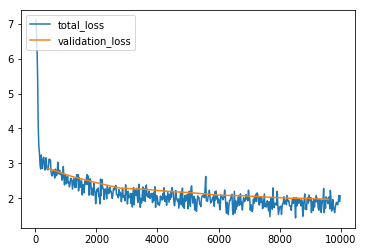

In [13]:
import json
import matplotlib.pyplot as plt

#experiment_folder = './output/model_iter4000_lr0005_wf1_date2020_03_20__05_16_45'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr('/home/wenjinyuan/project/outputs/metrics.json')

plt.plot(
    [x['iteration'] for x in experiment_metrics], 
    [x['total_loss'] for x in experiment_metrics])
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
plt.legend(['total_loss', 'validation_loss'], loc='upper left')
plt.show()

In [15]:
import math
bbox_dc5=list(results['bbox'].values())
bbox_dc5=bbox_dc5[6:-1]
bbox_dc5 = [x for x in bbox_dc5 if math.isnan(x) == False]

segm_dc5=list(results['segm'].values())
segm_dc5=segm_dc5[6:-1]
segm_dc5 = [x for x in segm_dc5 if math.isnan(x) == False]

bbox_fpn=[0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6.139,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,18.257,0.000,0.000,0.000,0.000,0.000,0.000,6.878,0.000,0.000,1.443,0.000,0.000,0.000,6.914,0.000,0.000,3.762,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,24.474,0.000,0.000,30.484,0.000,15.990,0.000,7.129,0.000,43.036,2.574,12.605,0.000,0.000,5.611,0.000,0.000,0.000,13.465,0.000,0.000,0.000,0.000,10.594,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.772,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.782,0.000,0.000,0.000,0.000,0.000,0.000,0.000,18.218,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,11.253,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.031,0.000,6.139,0.000,8.606,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,20.341,0.000,0.000,2.574,0.000,1.564,1.122,0.000,0.000,0.000,0.000,0.000,0.000,0.000,20.332,0.000,0.000,5.743,12.494,1.609,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,17.992,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000]
segm_fpn=[0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,14.455,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,28.415,0.000,0.000,0.000,0.000,0.000,0.000,9.347,0.000,0.000,2.574,0.000,0.000,0.000,12.200,0.000,0.000,29.579,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,50.293,0.000,0.000,30.723,0.000,21.320,0.000,8.020,0.000,50.693,11.584,27.652,0.000,0.000,39.802,0.000,0.000,0.000,26.931,0.000,0.000,0.000,0.000,14.851,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.772,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,10.891,0.000,0.000,0.000,0.000,0.000,4.257,0.000,0.000,0.000,0.000,0.000,0.000,0.000,18.812,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,14.282,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.772,2.351,0.000,10.297,0.000,27.756,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,43.247,0.000,0.000,6.436,8.416,1.109,5.330,0.000,0.000,0.000,0.000,0.000,0.000,0.000,29.904,0.000,0.000,13.188,26.834,2.574,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,33.097,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000]

In [27]:
from scipy.stats import mannwhitneyu

U1, p1 = mannwhitneyu(bbox_dc5, bbox_fpn, method="asymptotic")

U2, p2 = mannwhitneyu(segm_dc5, segm_fpn, method="asymptotic")

print(p1,p2)



0.4272308170394976 0.5103509153347021


In [ ]:
pip list